In [1]:
# Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys

# Load 'helper utilities'
from linkage_tools import *
l = Linker()
print('database name: '+l.connection.db)

# Load classifier objects
from Probabilistic import *
from Perceptron import *
from NeuralNetwork import *
from KerasModel import *

#import warnings
#warnings.filterwarnings('error')

# Display the output of plotting commands inline
%matplotlib inline

# Set print output toggle
verbose = True

database name: mdc_2017_09_07


Using Theano backend.


### Define linking variables

In [2]:
# Define tables
tableA = '''patient_discharges JOIN newborns
ON patient_discharges.id = newborns.patient_discharge_id
LEFT OUTER JOIN patient_payers AS newborn_payers
ON newborn_payers.patient_discharge_id = patient_discharges.id'''

tableB = '''births JOIN deliveries 
ON births.delivery_id = deliveries.id
JOIN patient_discharges AS delivery_discharges
ON deliveries.patient_discharge_id = delivery_discharges.id
LEFT OUTER JOIN patient_payers AS delivery_payers
ON delivery_payers.patient_discharge_id = delivery_discharges.id'''

# Define fields to compare tables by
tableA_fields = ['patient_discharges.sex_id','newborns.id','newborns.cesarean_section', 
            'patient_discharges.zip_code','patient_discharges.race_id','patient_discharges.ethnicity_id', 
                'newborn_payers.payer_type_of_coverage_id','patient_discharges.principal_language_spoken', 
                 'patient_discharges.discharged_on','newborn_payers.payer_category_id',
                 'newborn_payers.plan_code_number','newborns.birth_weight_group_id',
                 'newborns.gestational_age_group_id','newborns.plurality_group_id']

tableB_fields = ['births.sex_id','births.newborn_id','births.delivery_route_id', 
            'births.mothers_residence_zip_code','delivery_discharges.race_id','delivery_discharges.ethnicity_id', 
                'delivery_payers.payer_type_of_coverage_id','delivery_discharges.principal_language_spoken', 
                 'delivery_discharges.discharged_on','delivery_payers.payer_category_id',
                 'delivery_payers.plan_code_number','births.birth_weight',
                 'births.gestational_age_ob_estimate','births.plurality'] 

# Define new names for each comparison
simple_feature_names = ['sex_id','c_section','zip_code','race','ethnicity','payer_type_of_coverage_id',
                'language_spoken','discharge','payer_category_id','plan_code_number','plurality']

complex_feature_names = ['weight_group_id','gest_age_group_id']

simple_feature_num = 11

# Exact matching only
simple_features = [val for pair in zip([x+'_match' for x in simple_feature_names],
                                    [x+'_nomatch' for x in simple_feature_names]) for val in pair]

# Including non-exact matching
complex_features = [val for pair in zip([x+'_match' for x in complex_feature_names],
                     [x+'_fuzzymatch' for x in complex_feature_names],
                     [x+'_nomatch' for x in complex_feature_names]) for val in pair]

feature_vals = simple_features + complex_features

# Define bins to use for certain fields
age_bins = np.concatenate(([0,1,24], np.arange(25, 36, 2),[99]), axis=0)
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)

cesarean_ids = [1, 11, 21, 31, 2, 12, 22, 32]

In [3]:
def get_condition_vals(cross_table):
    condition_vals = [  (cross_table['sex_id_x'],cross_table['sex_id_y']),
                (cross_table['cesarean_section'],
                 pd.Series([x in cesarean_ids for x in cross_table['delivery_route_id']])),
                (cross_table['zip_code'],cross_table['mothers_residence_zip_code']),
                (cross_table['race_id_x'],cross_table['race_id_y']),
                (cross_table['ethnicity_id_x'],cross_table['ethnicity_id_y']),
                (cross_table['payer_type_of_coverage_id_x'],cross_table['payer_type_of_coverage_id_y']),
                ((cross_table['principal_language_spoken_x'].str[:3]).str.lower(),
                 (cross_table['principal_language_spoken_y'].str[:3]).str.lower()),
                (cross_table['discharged_on_x'],cross_table['discharged_on_y']),
                (cross_table['payer_category_id_x'],cross_table['payer_category_id_y']),
                (cross_table['plan_code_number_x'],cross_table['plan_code_number_y']),
                ((cross_table['plurality_group_id']==1),(cross_table['plurality']==1)),
                (cross_table['birth_weight_group_id'],
                     l.digitize_series(cross_table['birth_weight'],bw_bins)),
                (cross_table['gestational_age_group_id'],
                     l.digitize_series(cross_table['gestational_age_ob_estimate']/7,age_bins))  ] 
    return(condition_vals)

def getBools(cross_table):
    
    def bool_test(condition_val_pair):
        # Exact matching of fields
        condA,condB = condition_val_pair
        #condA,condB = pd.to_numeric(condA),pd.to_numeric(condB)
        fields_notnull = np.logical_and(condA.notnull(),condB.notnull())
        return(np.vstack([np.array(condA.values==condB.values)&fields_notnull,
                          np.array(condA.values!=condB.values)&fields_notnull]))
    
    def bool_test_complex(condition_val_pair):
        # 'Fuzzy' matching of fields
        condA,condB = condition_val_pair
        fields_notnull = np.logical_and(condA.notnull(),condB.notnull())
        condA,condB = pd.to_numeric(condA),pd.to_numeric(condB)
        condA,condB = np.nan_to_num(condA),np.nan_to_num(condB)
        return(np.vstack([np.squeeze(np.diff(zip(condA,condB))==0)&fields_notnull,
                          np.squeeze(np.diff(zip(condA,condB))==1)&fields_notnull,
                          np.squeeze(np.diff(zip(condA,condB))>1)&fields_notnull]))

    condition_vals = get_condition_vals(cross_table)
    simple_bools = [bool_test(x) for x in condition_vals[0:simple_feature_num]] # Simple features
    complex_bools = [bool_test_complex(x) for x in condition_vals[simple_feature_num:]] # Complex features

    return(np.concatenate(simple_bools+complex_bools).T)

#def getMissing(cross_table):
#    def none_test(condition_val_pair):
#        condA,condB = condition_val_pair
#        aNones = [x is None for x in condA]
#        bNones = [x is None for x in condB]
#        return(np.vstack([np.logical_or(aNones,bNones),np.logical_or(aNones,bNones)]))
#   condition_vals = get_condition_vals(cross_table)
#    return(np.concatenate([none_test(x) for x in condition_vals]).T)

### Blocking

In [4]:
# Find all possible values for 1st blocking field ('hospital_id')
stmt = '''
SELECT DISTINCT patient_discharges.hospital_id
FROM patient_discharges 
UNION
SELECT DISTINCT births.hospital_id
FROM births;'''
block_list1 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

# Find all possible values for 2nd blocking field ('date_of_delivery')
stmt = '''
SELECT DISTINCT births.date_of_delivery
FROM births;'''
block_list2 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

# List all possible combinations of blocks
block_prod = [(str(x),str(y)) for x in block_list1 for y in block_list2]
np.random.shuffle(block_prod)
block_prod_train = block_prod[:500]
block_prod_valid = block_prod[500:550]

# Assign strings to select each block
blocking_stmt1 = '''
        SELECT patient_discharges.id AS pdd_id, newborns.id AS newb_id,%s 
        FROM %s
        WHERE patient_discharges.hospital_id = %r
        AND patient_discharges.date_of_birth = %r;
        '''
blocking_stmt2 = '''
        SELECT births.id AS bc_id,%s
        FROM %s
        WHERE births.hospital_id = %r
        AND births.date_of_delivery = %r;
        '''

### Create classifiers
- Create [probabilistic] and [perceptron] classifier (each to be trained on subset of features ['simple' vs. 'complex'])
[perceptron]: http://glowingpython.blogspot.com/2011/10/perceptron.html
[probabilistic]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5005943/

In [5]:
learning_rate_pt = 0.001 # small, constant learning rate
learning_rate_nn = 0.001
learning_rate_km = 0.05

# Create instances of classifiers
classifiers = [Probabilistic(simple_features),
                Probabilistic(feature_vals),
                Perceptron(simple_features,learningrate = learning_rate_pt),
                Perceptron(feature_vals,learningrate = learning_rate_pt),
                NeuralNetwork(feature_vals,20,1,learningrate = learning_rate_nn),
                KerasModel(feature_vals,10,1,learningrate = learning_rate_km)]

classifier_names = ['prob_s','prob_c','pt_s','pt_c','nn_c','k_mod']
classifier_desc = ['prob(s)','prob(c)','ptron(s)','ptron(c)','neurnet(c)','keras(c)']

color_list = ['b','g','r','c','m','y'][slice(len(classifiers))]

### Iterate over each indexing block
- Loop over each block and convert to pandas dataframe
- Cross join the features-of-interest from both blocks
- Apply conditional statements to each column of dataframe
- Return match score from each learner
- Maximize pairing with Kuhn-Munkres (i.e. Hungarian) Algorithm [more info]
- Compare guesses to truth, update weights/probabilities

[more info]: https://pypi.python.org/pypi/munkres/

In [6]:
class_prog = [True] * len(classifiers)

block_duration = []
epoch_duration = []
epoch_count = 0
verb_str = '\rEpoch #{} [ blockA: {} records, blockB: {} records ]   ' # verbose output

while True:
    epoch_start = time.time() # Measure epoch duration

    def run_blocks(block_prod_list):
        
        big_bool = pd.DataFrame(columns=feature_vals)  
        
        for block1, block2 in block_prod_list:

            block_start = time.time() # Measure block duration

            # Create blocks
            blockA = l.exec_sql(blocking_stmt1 % (",".join(tableA_fields),tableA,block1,block2))
            blockB = l.exec_sql(blocking_stmt2 % (",".join(tableB_fields),tableB,block1,block2))

            if verbose:
                sys.stdout.write(verb_str.format(epoch_count, len(blockA), len(blockB)))
                sys.stdout.flush()

            # Check that neither block is empty - If empty, skip to next record-pair in loop
            if (len(blockA)==0) or (len(blockB)==0):
                continue

            # Cross-join both blocks
            cross_table = l.df_crossjoin(blockA, blockB)

            # Count field matches and dump each into new column of dataframe
            bool_table = pd.DataFrame.from_items(zip(feature_vals,getBools(cross_table).T))

            # Add record-id columns to boolean table
            bool_table['newb_id'] = cross_table['newb_id'].values # Actual newborn id
            bool_table['bc_id'] = cross_table['bc_id'].values  # Actual bc id
            bool_table['prev_newb_id'] = cross_table['newborn_id'].values # Originally matched newborn id 

            # Compare with previously-linked newborn id
            bool_table['real_match'] = (cross_table['newborn_id']==cross_table['newb_id']).values 
            for x in classifier_names:
                bool_table['match_'+x] = False # Create new columns for later
            
            # Get guesses from classifiers
            record_id = bool_table[['newb_id','bc_id']]
            for x,y in zip(classifiers,classifier_names):
                link_inds,link_score = x.query(bool_table[x.features],record_id) 
                #bool_table['lscore_'+y] = link_score
                bool_table.loc[link_inds,'match_'+y] = True # Label nominees as such  

            #link_inds,link_score = kmodel.query(bool_table[kmodel.features],record_id)
            #bool_table.loc[link_inds,'match_kmodel'] = True # Label nominees as such
                                   
            # Aggregate field-match tables (Booleans) within loop
            big_bool = pd.concat([big_bool,bool_table])

            # Time duration of each block
            block_duration.append(time.time()-block_start)
        
        return(big_bool)
    
    # Check progress of each classifier 
    big_bool_tr = run_blocks(block_prod_train)
    big_bool_val = run_blocks(block_prod_valid)
    
    # Make number of matches & non-matches (classes) in training data equivalent
    matches = big_bool_tr.loc[big_bool_tr['real_match']] # Select matches
    nonmatches = big_bool_tr.loc[big_bool_tr['real_match']==False] # Select non-matches
    # Shrink non-matches to same size as matches
    redux_nonmatches = nonmatches.iloc[np.random.choice(len(nonmatches), len(matches))]
    # Merge tables back together and shuffle
    train_data = pd.concat([matches,redux_nonmatches]).sample(frac=1)

    # Train classifiers (if still progressing)
    train_classifier = lambda x,y: \
        x.train(train_data[x.features],train_data['real_match'],train_data['match_'+y])
    map(train_classifier,classifiers,classifier_names)
        
    ## Measure accuracy of each classifier
    #score_list = [((big_bool['match_'+x]==big_bool['real_match'])*1).tolist() for x in classifier_names]
    #cur_scores = [sum(x)*100.0/len(x) for x in score_list]
    
    # Update precision & recall of classifiers
    for x,y in zip(classifiers,classifier_names):
        x.test_classifier(big_bool_tr['match_'+y],big_bool_tr['real_match'])

    # Validate classifiers  
    for x,y in zip(classifiers,classifier_names):
        x.val_classifier(big_bool_val['match_'+y],big_bool_val['real_match'])

    # Compare current iteration performance with previous
    cur_iter_qual = [x.train_fscore_list[-1] for x in classifiers]
    if epoch_count>0:
        prev_iter_qual = [x.train_fscore_list[-2] for x in classifiers]
        class_prog = np.subtract(cur_iter_qual,prev_iter_qual)>.1
    
    # If not improving, break from outer loop
    if not any(class_prog):
        print str.format('\n'+'-'*80+"\nQuality threshold achieved! @ {}",[ float('%.2f' % x) for x in cur_iter_qual ])        
        break

    # Time duration of each iteration
    epoch_duration.append(time.time()-epoch_start)
    
    epoch_count += 1 # Increment epoch counter
    
    if verbose:
        print str.format('\nAverage block duration: {0:.2f} seconds', np.mean(block_duration))
        print str.format("F-scores: {}", [ float('%.2f' % x) for x in cur_iter_qual ])
        print str.format('Average epoch duration: {0:.3f} minutes', np.mean(epoch_duration)/60.0)

Epoch #0 [ blockA: 8 records, blockB: 8 records ]   

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_APqrit.c:4:19: fatal error: cudnn.h: No such file or directory
 #include <cudnn.h>
                   ^
compilation terminated.

Mapped name None to device cuda: GeForce GT 610 (0000:07:00.0)


Epoch #0 [ blockA: 5 records, blockB: 5 records ]     
Average block duration: 0.29 seconds
F-scores: [10.19, 16.07, 11.47, 90.03, 15.04, 6.56]
Average epoch duration: 2.671 minutes
Epoch #1 [ blockA: 5 records, blockB: 5 records ]     
Average block duration: 0.25 seconds
F-scores: [98.93, 98.93, 98.68, 98.79, 98.9, 97.92]
Average epoch duration: 2.358 minutes
Epoch #2 [ blockA: 5 records, blockB: 5 records ]     
Average block duration: 0.24 seconds
F-scores: [98.86, 98.97, 98.68, 98.71, 98.9, 98.82]
Average epoch duration: 2.252 minutes
Epoch #3 [ blockA: 5 records, blockB: 5 records ]     
Average block duration: 0.24 seconds
F-scores: [98.9, 98.97, 98.79, 98.68, 98.9, 98.9]
Average epoch duration: 2.201 minutes
Epoch #4 [ blockA: 5 records, blockB: 5 records ]     
--------------------------------------------------------------------------------
Quality threshold achieved! @ [98.97, 98.97, 98.75, 98.68, 98.9, 98.9]


### Plot accuracy for each classifier over all epochs

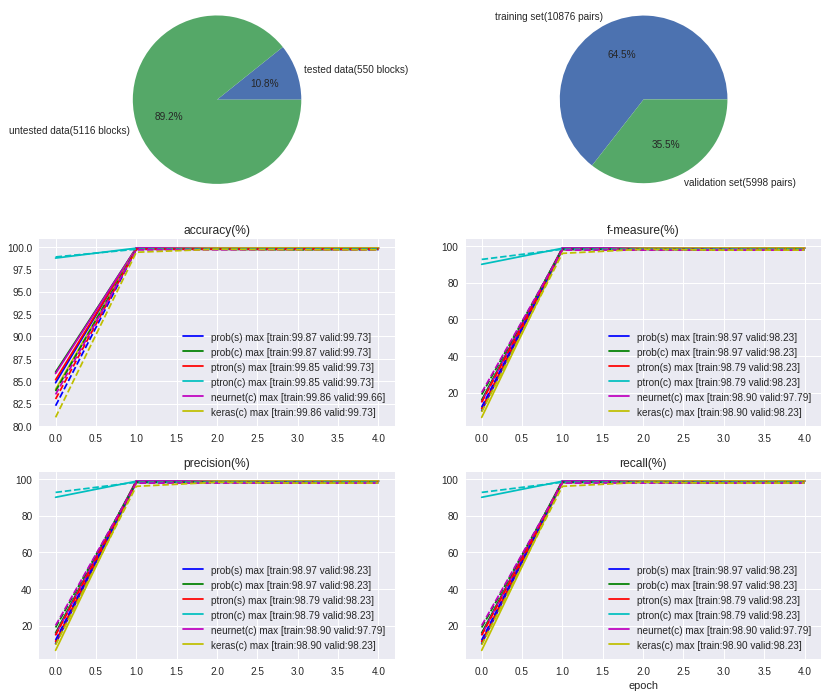

In [10]:
import matplotlib
matplotlib.style.use('seaborn')

def plot_classifiers(ax,train_list,val_list,title,xlabel):

    M_tr = np.array(train_list).T
    M_val = np.array(val_list).T
    for i in range(M_tr.shape[1]):
        ax.plot(range(M_tr.shape[0]), M_tr[:,i],'-',color=color_list[i],
                 label=classifier_desc[i] + ' max [train:' + str('%.2f' % np.max(M_tr[:,i])) + 
                 ' valid:' + str('%.2f' % np.max(M_val[:,i])) + ']')
    
    for i in range(M_val.shape[1]):
        ax.plot(range(M_val.shape[0]), M_val[:,i],'--',color=color_list[i])
    
    ax.legend(loc='lower right')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

nrow = 3; ncol = 2
fig = plt.figure(figsize=(nrow,ncol))

len_tested = len(block_prod_train)+len(block_prod_valid)

ax1 = fig.add_subplot(nrow,ncol,1)
plt.pie([len_tested,len(block_prod)-len_tested],
        labels=['tested data('+str(len_tested)+' blocks)',
                'untested data('+str(len(block_prod))+' blocks)'],autopct='%1.1f%%')
ax1.axis('equal')

ax2 = fig.add_subplot(nrow,ncol,2)
plt.pie([len(train_data),len(big_bool_val)],
        labels=['training set('+str(len(train_data))+' pairs)',
                'validation set('+str(len(big_bool_val))+' pairs)'],autopct='%1.1f%%')
ax2.axis('equal')

ax3 = fig.add_subplot(nrow,ncol,3)
plot_train_list = [o.train_accuracy_list for o in classifiers]
plot_val_list = [o.val_accuracy_list for o in classifiers]
plot_classifiers(ax3,plot_train_list,plot_val_list,'accuracy(%)','')

ax4 = fig.add_subplot(nrow,ncol,4)
plot_train_list = [o.train_fscore_list for o in classifiers]
plot_val_list = [o.val_fscore_list for o in classifiers]
plot_classifiers(ax4,plot_train_list,plot_val_list,'f-measure(%)','')

ax5 = fig.add_subplot(nrow,ncol,5)
plot_train_list = [o.train_precision_list for o in classifiers]
plot_val_list = [o.val_precision_list for o in classifiers]
plot_classifiers(ax5,plot_train_list,plot_val_list,'precision(%)','')

ax6 = fig.add_subplot(nrow,ncol,6)
plot_train_list = [o.train_recall_list for o in classifiers]
plot_val_list = [o.val_recall_list for o in classifiers]
plot_classifiers(ax6,plot_train_list,plot_val_list,'recall(%)','epoch')

fig.subplots_adjust(hspace=.25)
fig.set_size_inches(7*ncol,4*nrow)
plt.show()
fig.savefig('classifier_val_scores.png', bbox_inches='tight')

### Plot summary of record data tables

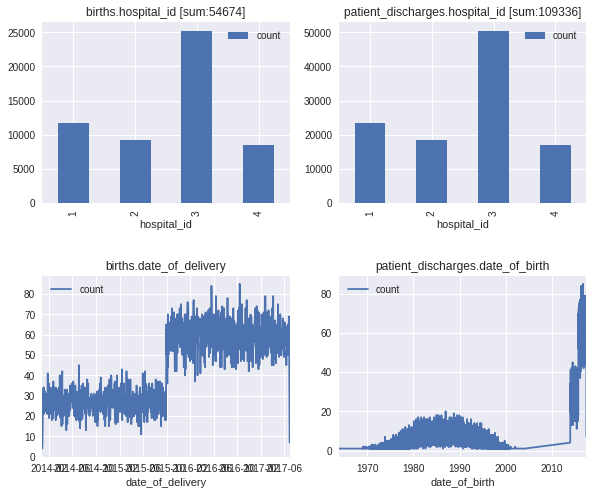

In [8]:
nrow = 2; ncol = 2
fig = plt.figure(figsize=(nrow,ncol))

ax1 = fig.add_subplot(nrow,ncol,1)
bc_hosp_str = "SELECT births.hospital_id,COUNT(*) as count FROM births GROUP BY births.hospital_id;"
bc_hosp_vals = l.exec_sql(bc_hosp_str)
bc_tot = l.exec_sql("SELECT COUNT(*) FROM births")
bc_hosp_vals.plot.bar(x='hospital_id',ax=ax1,title='births.hospital_id [sum:' + str(bc_tot.values[0][0]) + ']')

ax2 = fig.add_subplot(nrow,ncol,2)
pdd_hosp_str = "SELECT patient_discharges.hospital_id,COUNT(*) as count FROM patient_discharges GROUP BY patient_discharges.hospital_id;"
pdd_hosp_vals = l.exec_sql(pdd_hosp_str)
pdd_tot = l.exec_sql("SELECT COUNT(*) FROM patient_discharges")
pdd_hosp_vals.plot.bar(x='hospital_id',ax=ax2,title='patient_discharges.hospital_id [sum:' + str(pdd_tot.values[0][0]) + ']')

ax3 = fig.add_subplot(nrow,ncol,3)
bc_bday_str = "SELECT births.date_of_delivery,COUNT(*) as count FROM births GROUP BY births.date_of_delivery;"
bc_bday_vals = l.exec_sql(bc_bday_str)
bc_bday_vals.plot(ax=ax3,x = 'date_of_delivery',title = 'births.date_of_delivery')

ax4 = fig.add_subplot(nrow,ncol,4)
pdd_bday_str = "SELECT patient_discharges.date_of_birth,COUNT(*) as count FROM patient_discharges GROUP BY patient_discharges.date_of_birth;"
pdd_bday_vals = l.exec_sql(pdd_bday_str)
pdd_bday_vals.plot(ax=ax4,x = 'date_of_birth', title = 'patient_discharges.date_of_birth')

fig.subplots_adjust(hspace=.4)
fig.set_size_inches(4.875*ncol,4*nrow)
fig.savefig('block_sizes.png', bbox_inches='tight')

### Show table of weights/probabilities for each classifier

In [15]:
import itable

# Assemble table elements into dataframe
pt_simple_weights = classifiers[2].weights.tolist()[:-1] + \
    [None]*len(complex_features) + [classifiers[2].weights.tolist()[-1]]

weight_list = [['prob_simple'] + classifiers[0].m_probs.tolist() + [None],
               ['prob_complex'] + classifiers[1].m_probs.tolist() + [None],
               ['perc_simple'] + pt_simple_weights,
               ['perc_complex'] + classifiers[3].weights.tolist()]
df = pd.DataFrame(weight_list, columns=['classifier']+feature_vals+['bias'])

# Save table as html file
my_file = open('weights.html', 'w')
my_file.write(df.to_html())
#pt_simple_weights = classifiers[2].weights.tolist()
my_file.close()

# Show table as ipython figure
itable.PrettyTable(df)

classifier,sex_id_match,sex_id_nomatch,c_section_match,c_section_nomatch,zip_code_match,zip_code_nomatch,race_match,race_nomatch,ethnicity_match,ethnicity_nomatch,payer_type_of_coverage_id_match,payer_type_of_coverage_id_nomatch,language_spoken_match,language_spoken_nomatch,discharge_match,discharge_nomatch,payer_category_id_match,payer_category_id_nomatch,plan_code_number_match,plan_code_number_nomatch,plurality_match,plurality_nomatch,weight_group_id_match,weight_group_id_fuzzymatch,weight_group_id_nomatch,gest_age_group_id_match,gest_age_group_id_fuzzymatch,gest_age_group_id_nomatch,bias
prob_simple,0.981024667932,0.0185009487666,0.992409867173,0.00759013282732,0.895161290323,0.103889943074,0.890891840607,0.102466793169,0.933586337761,0.0645161290323,0.0,0.0,0.916034155598,0.0787476280835,0.890417457306,0.109582542694,0.0,0.0,0.0,0.0,0.996204933586,0.00379506641366,nan,nan,nan,nan,nan,nan,nan
prob_complex,0.981024667932,0.0185009487666,0.992409867173,0.00759013282732,0.895161290323,0.103889943074,0.890891840607,0.102466793169,0.933586337761,0.0645161290323,0.0,0.0,0.916034155598,0.0787476280835,0.890417457306,0.109582542694,0.0,0.0,0.0,0.0,0.996204933586,0.00379506641366,0.076375711575,0.00569259962049,0.000474383301708,0.0445920303605,0.0716318785579,0.00189753320683,nan
perc_simple,14.9756052578,-14.9821836876,0.165228567641,-0.165705402598,16.9466069364,-16.9343576373,15.8023694142,-15.8127165231,12.6697030038,-12.6692080655,0.00902179801272,0.00555401178594,3.33025667212,-3.33002813906,2.00377015014,-2.01972945706,0.00178702274153,-0.00532458834501,0.000680941094566,0.00224023011689,1.95375899456,-1.95284294058,nan,nan,nan,nan,nan,nan,0.00894549382414
perc_complex,0.625412755749,-0.617133943728,1.26053665737,-1.25903667607,1.69771383109,-1.68794997676,0.238962895236,-0.247801759969,0.114620767972,-0.112326890011,-0.00770795103945,0.00970571567555,0.231849030812,-0.230658364141,0.807780056103,-0.796405555595,-0.00487802246161,-0.0040530087758,-0.000670760572659,-0.00100497836549,1.91322063187,-1.91371700726,0.563531152275,-0.189731123446,-0.29415407207,-0.00994070815628,0.420105650789,-0.357070636284,0.00102084488835


### Organize and export 'wrong answers' to spreadsheet (.csv) files [1 spreadsheet/classifier]

In [16]:
import csv

# Select features to export
feature_list = ['bc_id','real_match','newb_id']+feature_vals

# Gather incorrect matches for each classifier
score_list = [((big_bool['match_'+x]==big_bool['real_match'])*1).tolist() for x in classifiers]

for sc,cl in zip(score_list,classifiers):
    errors = big_bool[feature_list].iloc[[x==0 for x in sc],:].sort(['bc_id','real_match'], ascending=[1,0])
    errors.to_csv('linkage_error_'+cl+'.csv')

TypeError: cannot concatenate 'str' and 'instance' objects